# Training a mask/no mask classification model

Notebook to train a mask/no mask classification model.   
The input are images of faces that are already cropped. 

We use this notebook with three kinds of images:  
    - Images of faces without mask  
    - Images of faces with an artificial mask  
    - Images of faces with a real mask

We train a MobileNet base followed by a Global Average Pooling layer, 2 fully connected layers and finally a sigmoid.

In [25]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import MobileNetV2
from keras.applications.mobilenet import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.mobilenet import preprocess_input

import keras 

from sklearn import metrics 
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import itertools
import random

## Setup

In [44]:
target_size = (112,112)
batch_size = 32
lr = 0.01
n_epochs = 5

model_dir = Path('models')
model_dir.mkdir(exist_ok=True)

In [27]:
# all frames contain 'image' (filepath of image), 'label' (with_mask or no_mask) and 'artificial' (yes or no)
# the validatoin frame also contains the 'real_evaluation' column 
# this selects a subset of the non-masked images to be used in the 'real' validation set
# we don't use all non-masked images in this 'real' validation set, as this would lead to strong imbalance w.r.t. masked images
# so this column will be yes for a subset of all non-masked images

train_frame = pd.DataFrame(columns=['image', 'label', 'artificial'])
val_frame = pd.DataFrame(columns=['image', 'label', 'artificial', 'real_evaluation'])
test_frame = pd.DataFrame(columns=['image', 'label', 'artificial'])

train_path = Path('images/train')
train_path_masked = train_path / 'masked'
train_path_not_masked = train_path / 'not_masked'

real_masked_path = Path('images/real_masked_faces_ground_truth_crop')

# artificially masked data is divided over train and validation
train_pct_artificial_masked = 0.7
valid_pct_artificial_masked = 0.3

# real not masked data is divided over train/validation/test
train_pct_real_not_masked = 0.6
val_pct_real_not_masked = 0.3
test_pct_real_not_masked = 0.1

# real masked data is divided over validation/test
valid_pct_real_masked = 0.5
test_pct_real_masked = 0.5

## divide artificial masked over train/validation
artificial_masked_fns = list(train_path_masked.glob('*.jpg'))

for fn in artificial_masked_fns[:int(train_pct_artificial_masked*len(artificial_masked_fns))]:
    train_frame.loc[len(train_frame)] = [fn, 'with_mask', 'yes']  

for fn in artificial_masked_fns[int(train_pct_artificial_masked*len(artificial_masked_fns)):]:
    val_frame.loc[len(val_frame)] = [fn, 'with_mask', 'yes', 'no']
    
    
## divide not_masked over train/validation/test
not_masked_fns = list(train_path_not_masked.glob('*.jpg'))

for fn in not_masked_fns[:int(train_pct_real_not_masked*len(not_masked_fns))]:
    train_frame.loc[len(train_frame)] = [fn, 'no_mask', 'no']
    
not_masked_val_idxs = []
for fn in not_masked_fns[int(train_pct_real_not_masked*len(not_masked_fns)):int((train_pct_real_not_masked + val_pct_real_not_masked)*len(not_masked_fns))]:
    not_masked_val_idxs.append(len(val_frame))
    val_frame.loc[len(val_frame)] = [fn, 'no_mask', 'no', 'no']

not_masked_real_eval_set = random.sample(not_masked_val_idxs, int(valid_pct_real_masked*len(list(real_masked_path.glob('*.jpg'))))) # make sure we have a balanced real validation set
for idx in not_masked_real_eval_set:
    val_frame.at[idx, 'real_evaluation'] = 'yes'

for fn in not_masked_fns[int((train_pct_real_not_masked + val_pct_real_not_masked)*len(not_masked_fns)):]:
    test_frame.loc[len(test_frame)] = [fn, 'no_mask', 'no']
    
    
## divide real masked over validation/test
real_masked_fns = list(real_masked_path.glob('*.jpg'))
for fn in real_masked_fns[:int(valid_pct_real_masked*len(real_masked_fns))]:
    val_frame.loc[len(val_frame)] = [fn, 'with_mask', 'no', 'yes']
    
for fn in real_masked_fns[int(valid_pct_real_masked*len(real_masked_fns)):]:
    test_frame.loc[len(test_frame)] = [fn, 'with_mask', 'no']
    

## some checks to see whether the numbers add up
n_artificial_masked_train = len(train_frame[(train_frame.label == 'with_mask') & (train_frame.artificial == 'yes')])
n_artificial_masked_val = len(val_frame[(val_frame.label == 'with_mask') & (val_frame.artificial == 'yes')])
assert(n_artificial_masked_train + n_artificial_masked_val == len(artificial_masked_fns))

n_not_masked_train = len(train_frame[train_frame.label == 'no_mask'])
n_not_masked_val = len(val_frame[val_frame.label == 'no_mask'])
n_not_masked_test = len(test_frame[test_frame.label == 'no_mask'])
assert(n_not_masked_train + n_not_masked_val + n_not_masked_test == len(not_masked_fns))

n_real_masked_val = len(val_frame[(val_frame.label == 'with_mask') & (val_frame.artificial == 'no')])
n_real_masked_test = len(test_frame[(test_frame.label == 'with_mask') & (test_frame.artificial == 'no')])
assert(n_real_masked_val + n_real_masked_test == len(real_masked_fns))

n_real_unmasked_val = len(val_frame[(val_frame.label == 'no_mask') & (val_frame.real_evaluation == 'yes')])
assert(n_real_unmasked_val == n_real_masked_val)

## Defining the model

MobileNet base with 3 fully connected layers on top and one final layer with sigmoid activation that outputs prediction.  
Only the fully connected layers are trained, the MobileNet base is frozen.

In [28]:
base_model = MobileNet(weights='imagenet',include_top=False, input_shape=(target_size[0],target_size[1],3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x) 
x = Dense(512,activation='relu')(x) 
x = Dense(256,activation='relu')(x) 
preds = Dense(1,activation='sigmoid')(x)

/home/toon/mask_env_37/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [29]:
model = Model(inputs=base_model.input,outputs=preds)

In [30]:
# we only train the final fully connected layers, not the mobilenet base
for layer in model.layers[:-4]:
    layer.trainable = False

## Setting up train and validation generators

In [31]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
                                                #horizontal_flip='True',
                                                #zoom_range=0.2,
                                                #rotation_range=25)

train_frame.image = train_frame.image.astype(str)
train_generator = train_datagen.flow_from_dataframe(train_frame,
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=True,
                                                    x_col='image',
                                                    y_col='label')

Found 1608 validated image filenames belonging to 2 classes.


In [32]:
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_frame.image = val_frame.image.astype(str)
val_generator = val_datagen.flow_from_dataframe(val_frame, 
                                                shuffle=False,
                                                target_size=target_size,
                                                batch_size=batch_size,
                                                class_mode='binary',
                                                x_col='image',
                                                y_col='label')

Found 865 validated image filenames belonging to 2 classes.


## Callback to report performance on real and artificial data separately

In [51]:
class SubsetAccuracy(keras.callbacks.Callback):
    """
    We want to monitor accuracy in the validation set separately for real and artificial face masks.
    This callback will print this to the output, and store the values for each epoch.
    """
    
    def __init__(self, val_gen=None, val_df=None):
        self.val_gen = val_gen
        self.val_df = val_df
        
        artificial_idx = val_df.index[val_df.artificial == "yes"].tolist()
        real_masked_idx = val_df.index[(val_df.artificial == "no") & (val_df.label == "with_mask")].tolist()
        non_masked_idx = val_df.index[val_df.label == "no_mask"].tolist()
        non_masked_real_eval_idx = val_df.index[(val_df.label == "no_mask") & (val_df.real_evaluation == "yes")].tolist()
        
        # the 'real' validation subset consists of a subset of masked images
        # and all real masked images
        self.real_eval_idxs = non_masked_real_eval_idx + real_masked_idx
        self.real_eval_ground_truth = [0] * len(non_masked_real_eval_idx) + [1] * len(real_masked_idx)
        
        # the 'artificial' validation subset consists of all non-masked images,
        # and all artificial masked images
        self.artificial_eval_idxs = non_masked_idx + artificial_idx
        self.artificial_eval_ground_truth = [0] * len(non_masked_idx) + [1] * len(artificial_idx)
        
        # these will store accuracies for different sets after each epoch
        self.acc_all = []
        self.acc_real = []
        self.acc_artificial = []
        
        self.cur_best_acc_on_real = 0.0
        
    def on_epoch_end(self, batch, logs={}):
        pred = self.model.predict_generator(self.val_gen)
        pred = [x[0] > 0.5 for x in pred]

        accuracy_all = metrics.accuracy_score(self.val_gen.labels, pred)
        print(f"The accuracy for the full validation set is {accuracy_all:.3f}")
                
        real_eval_preds = [pred[idx] for idx in self.real_eval_idxs]
        accuracy_real = metrics.accuracy_score(self.real_eval_ground_truth, real_eval_preds)
        print(f"The accuracy for the validation set with only real masked faces is: {accuracy_real:.3f}")

        artifical_eval_preds = [pred[idx] for idx in self.artificial_eval_idxs]
        accuracy_artificial = metrics.accuracy_score(self.artificial_eval_ground_truth, artifical_eval_preds)
        print(f"The accuracy for the validation set with only artificial masked faces is: {accuracy_artificial:.3f}")
        
        if accuracy_real > self.cur_best_acc_on_real:
            self.model.save(model_dir / 'best.h5')
            self.cur_best_acc_on_real = accuracy_real
        
        self.acc_all.append(accuracy_all)
        self.acc_real.append(accuracy_real)
        self.acc_artificial.append(accuracy_artificial)
    
          
subset_acc = SubsetAccuracy(val_generator, val_frame)

## Compile and fit the model

In [52]:
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
step_size_train = train_generator.n//train_generator.batch_size
step_size_val = val_generator.n//val_generator.batch_size

In [53]:
model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train, epochs=n_epochs, validation_data=val_generator, validation_steps=step_size_val, callbacks=[subset_acc])

Epoch 1/5
50/50 [==============================] - 15s 302ms/step - loss: 0.1087 - accuracy: 0.9879 - val_loss: 0.1649 - val_accuracy: 0.9630
The accuracy for the full validation set is 0.963
The accuracy for the validation set with only real masked faces is: 0.943
The accuracy for the validation set with only artificial masked faces is: 0.961
Epoch 2/5
50/50 [==============================] - 14s 290ms/step - loss: 0.0387 - accuracy: 0.9930 - val_loss: 0.1715 - val_accuracy: 0.9880
The accuracy for the full validation set is 0.986
The accuracy for the validation set with only real masked faces is: 0.955
The accuracy for the validation set with only artificial masked faces is: 0.997
Epoch 3/5
50/50 [==============================] - 15s 291ms/step - loss: 0.0600 - accuracy: 0.9898 - val_loss: 3.3236e-23 - val_accuracy: 0.8535
The accuracy for the full validation set is 0.859
The accuracy for the validation set with only real masked faces is: 0.809
The accuracy for the validation set wi

## Inspect validation set performance statistics

In [54]:
best_model = keras.models.load_model(model_dir / 'best.h5')

In [55]:
val_pred = best_model.predict_generator(val_generator)

#### Helper functions

In [56]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def print_stats(true_labels, pred):
    pred_bin = [x > 0.5 for x in pred]
    acc = metrics.accuracy_score(true_labels, pred_bin)
    print(f"Accuracy = {acc:.3f}")

    cm = metrics.confusion_matrix(true_labels, pred_bin)
    plot_confusion_matrix(cm, ['not masked', 'masked'])

    fpr, tpr, thr = metrics.roc_curve(true_labels, pred)
    auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=15)
    plt.ylabel('True Positive Rate', size=15)
    plt.title(f'AUC = {auc:.3f}', size=15)

#### Performance on full validation set

Accuracy = 0.985


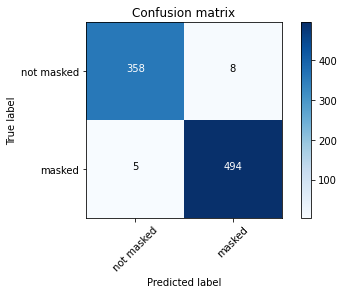

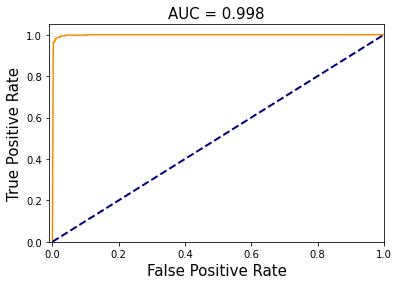

In [57]:
true_all = [1 if x == 'with_mask' else 0 for x in val_frame.label]
pred = [x[0] for x in val_pred]
print_stats(true_all, pred)

#### Performance with only real masked data as positive class

Accuracy = 0.967


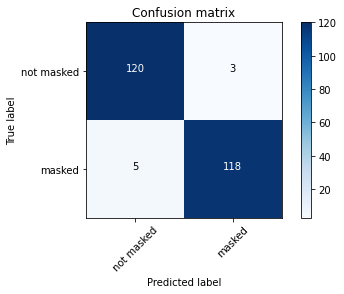

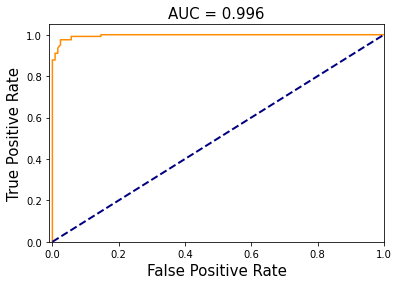

In [59]:
real_masked_idx = val_frame.index[(val_frame.artificial == "no") & (val_frame.label == "with_mask")].tolist()
non_masked_idx = val_frame.index[(val_frame.label == "no_mask") & (val_frame.real_evaluation == "yes")].tolist()
real_eval_idxs = non_masked_idx + real_masked_idx

true_real = [true_all[idx] for idx in real_eval_idxs]
pred_real = [pred[idx] for idx in real_eval_idxs]

print_stats(true_real, pred_real)

#### Performance with only artificially masked data as positive class

Accuracy = 0.989


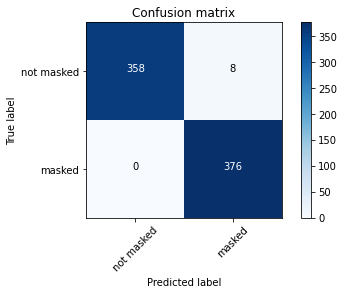

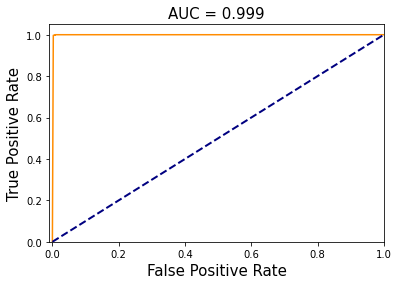

In [60]:
artificial_masked_idx = val_frame.index[(val_frame.artificial == "yes") & (val_frame.label == "with_mask")].tolist()
non_masked_idx = val_frame.index[val_frame.label == "no_mask"].tolist()
artificial_eval_idxs = artificial_masked_idx + non_masked_idx

true_artificial = [true_all[idx] for idx in artificial_eval_idxs]
pred_artificial = [pred[idx] for idx in artificial_eval_idxs]

print_stats(true_artificial, pred_artificial)

## Inspect mistakes on the real masked faces

In [61]:
real_masked_idx = val_frame.index[(val_frame.artificial == "no") & (val_frame.label == "with_mask")].tolist()
non_masked_idx = val_frame.index[(val_frame.label == "no_mask") & (val_frame.real_evaluation == "yes")].tolist()
real_eval_idxs = non_masked_idx + real_masked_idx

true_real = [true_all[idx] for idx in real_eval_idxs]
pred_real = [pred[idx] > 0.5 for idx in real_eval_idxs]

fps = []
fns = []
for idx, (true_label, pred_label) in enumerate(zip(true_real, pred_real)):
    if true_label == 1 and pred_label == 0:
        fns.append(real_eval_idxs[idx])
    elif true_label == 0 and pred_label == 1:
        fps.append(real_eval_idxs[idx])

False positives: model predicts mask, but true label is no mask


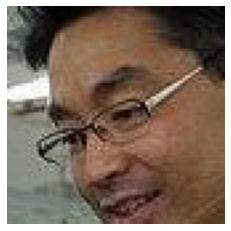

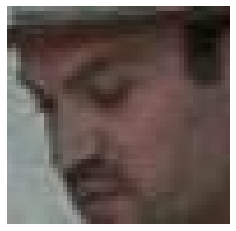

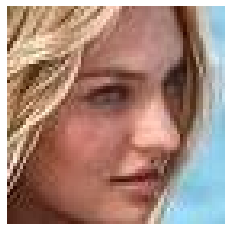

In [62]:
print("False positives: model predicts mask, but true label is no mask")
for x in fps:
    img = cv2.imread(val_frame.iloc[x]['image'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

False negatives: model predicts no mask, but true label is mask


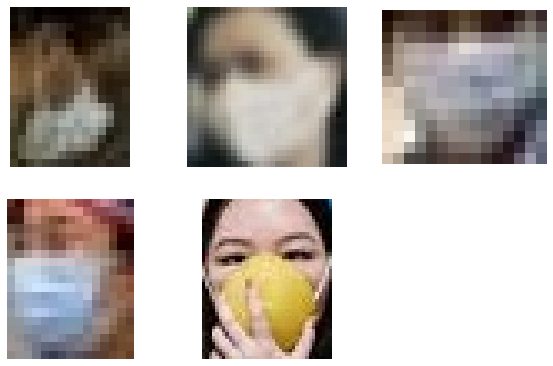

In [63]:
print("False negatives: model predicts no mask, but true label is mask")

nrow = np.ceil(np.sqrt(len(fns)))
ncol = nrow

plt.figure(figsize=(10,10))
for idx, x in enumerate(fns):
    plt.subplot(nrow, ncol, idx+1)
    img = cv2.imread(val_frame.iloc[x]['image'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
plt.show()